# TM10007 Assignment ECG data, Group 4

## Importing modules, downloading and cleaning data

In [ ]:
# Importing all the relevant modules

import zipfile
import os
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer


# Downloading the data
with zipfile.ZipFile('ecg/ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


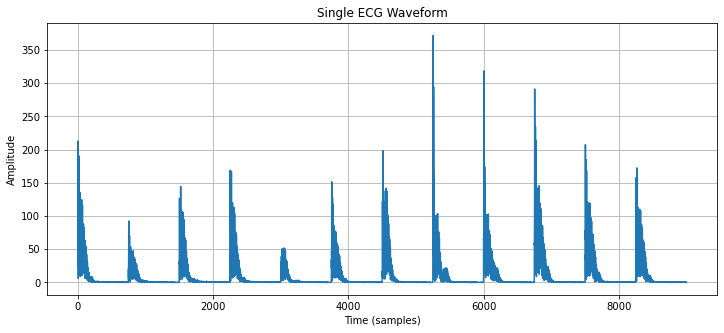

In [ ]:
# Select the first row (single ECG waveform)
sample_ecg = data.iloc[0, 1:-1]  # Exclude index and label

# Plot the ECG waveform
plt.figure(figsize=(12, 5))  
plt.plot(sample_ecg.values)  
plt.title('Single ECG Waveform')  
plt.xlabel('Time (samples)')  
plt.ylabel('Amplitude')  
plt.grid(True)  
plt.show()


1. Preprocessing

1.1 Check for missing data

In [ ]:
def handle_missing_values(data, feature_threshold=0.3, patient_threshold=0.3):
    """
    Handles missing values in the dataset by:
    1. Removing features (columns) with more than a given percentage of missing values.
    2. Removing patients (rows) with more than a given percentage of missing values.
    3. Imputing remaining missing values using the median per feature.
    
    Parameters:
        data (pd.DataFrame): The input dataset.
        feature_threshold (float): Maximum allowed proportion of missing values per feature before removal.
        patient_threshold (float): Maximum allowed proportion of missing values per patient before removal.
    
    Returns:
        pd.DataFrame: Cleaned dataset with missing values handled.
    """

    total_missing = data.isnull().sum().sum()
    print(f"Total missing values: {total_missing}")

    if total_missing == 0:
        return data

    print("Handling missing values...")

    # Define absolute thresholds based on proportions
    feature_missing_threshold = feature_threshold * len(data)  
    patient_missing_threshold = patient_threshold * len(data.columns)  

    # Step 1: Remove features with more than the allowed missing value percentage
    features_to_drop = data.columns[data.isnull().sum() > feature_missing_threshold]
    if len(features_to_drop) > 0:
        data = data.drop(columns=features_to_drop)
        print(f"Dropped features due to excessive missing values: {list(features_to_drop)}")

    # Step 2: Remove patients with more than the allowed missing value percentage
    patients_to_drop = data.index[data.isnull().sum(axis=1) > patient_missing_threshold]
    if len(patients_to_drop) > 0:
        data = data.drop(index=patients_to_drop)
        print(f"Dropped {len(patients_to_drop)} patients due to excessive missing values.")

    # Step 3: Impute remaining missing values using median per feature
    imputer = SimpleImputer(strategy='median')
    data[:] = imputer.fit_transform(data)
    print("Applied median imputation to remaining missing values.")

    return data

data_cleaned = handle_missing_values(data)

Total missing values: 0


1.2 Outliers (denk dat wij dit niet gaan/moeten toepassen)

In [5]:
def remove_outliers_zscore(data, threshold=4):
    """
    Removes rows containing features with Z-score greater than the threshold.
    Parameters:
        data (pd.DataFrame): The input dataset.
        threshold (float): The Z-score threshold for identifying outliers.
    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    # Compute the Z-scores
    z_scores = (data - data.mean()) / data.std()
    
    # Identify rows where any feature has a Z-score above the threshold
    outliers = (np.abs(z_scores) > threshold).any(axis=1)
    
    # Remove outliers
    data_cleaned = data[~outliers]
    
    print(f"Data shape before removing outliers: {data.shape}")
    print(f"Data shape after removing outliers: {data_cleaned.shape}")
    
    return data_cleaned

# Apply the function to your dataset
data_cleaned = remove_outliers_zscore(data)

Data shape before removing outliers: (827, 9001)
Data shape after removing outliers: (426, 9001)


1.3 Split into train, test and validation set

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Splits features en labels
X = data.iloc[:, :-1].values  # Alle kolommen behalve de laatste zijn de features
y = data.iloc[:, -1].values   # De laatste kolom is de label (0 of 1)

# Stap 1: Split the dataset in 80% training and 20% testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Stap 2: Splits de trainingsset verder in 80% train en 20% validatieset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Stap 3: Stratified K-Fold Cross-Validation (k=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Voorbeeld van hoe je de gesplitste data door de cross-validation heen zou kunnen laten lopen
#for train_idx, val_idx in kf.split(X_train, y_train):
#    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
#    print(f"Training fold size: {len(X_train_fold)}, Validation fold size: {len(X_val_fold)}")


1.4 Standardization (niet nodig als we Random Forest/XGBoost gebruiken)

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialiseer de scaler
scaler = StandardScaler()

# Pas de transformatie toe op alle numerieke features
X_scaled = scaler.fit_transform(X) # mean 0 and sd 1

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Loading ECG data and seperating labels & features
df = pd.read_csv("ecg/ecg_data.csv")
df = df.drop(columns=['Unnamed: 0'])  # Drop index column if exists
X = df.drop(columns=['label'])
y = df['label']

# Select low-frequency features: first 100 bins from each lead
low_freq_features = [col for col in X.columns if int(col.split('_')[1]) < 100]
X_low_freq = X[low_freq_features]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_low_freq)

# Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest with class balancing
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  
)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       137
           1       1.00      0.10      0.19        29

    accuracy                           0.84       166
   macro avg       0.92      0.55      0.55       166
weighted avg       0.87      0.84      0.79       166


Confusion Matrix:
[[137   0]
 [ 26   3]]

ROC AUC Score: 0.7791341555499621


C:\Users\aryav\AppData\Local\Temp\ipykernel_16044\1950893217.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\aryav\AppData\Local\Temp\ipykernel_16044\1950893217.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\aryav\AppData\Local\Temp\ipykernel_16044\1950893217.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\aryav\AppData\Local\Temp\ipykernel_16044\1950893217.py:22: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is depreca

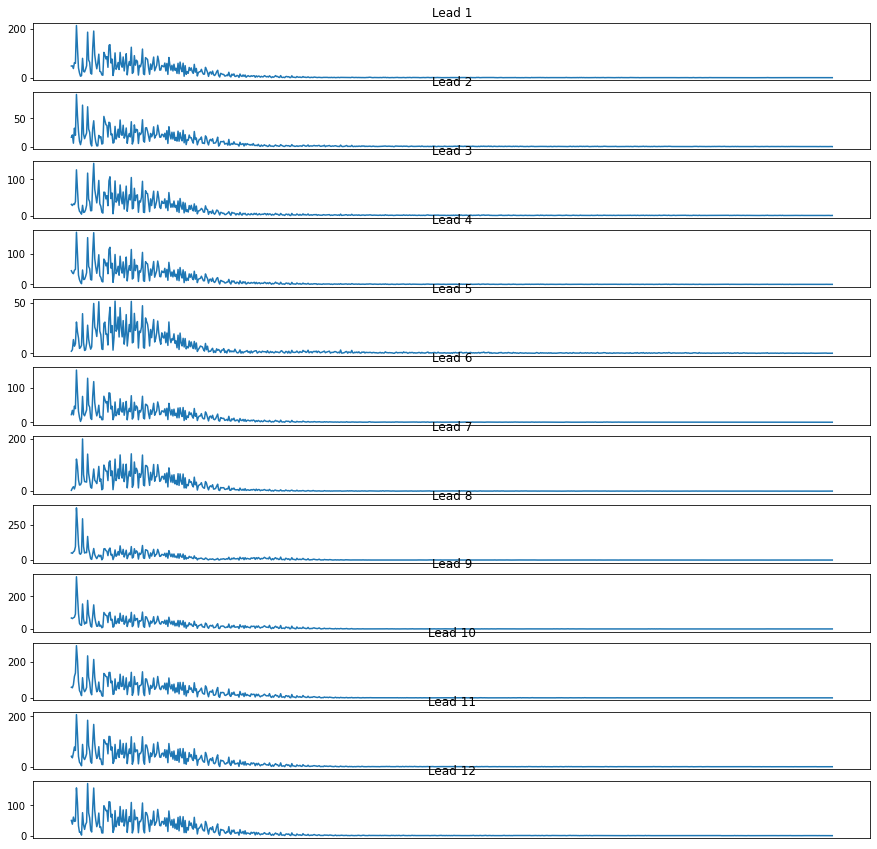

In [ ]:
import matplotlib.pyplot as plt

# Select the first row (single ECG waveform)
sample_ecg = data.iloc[0, :-1]  # Exclude index and label

num_leads = 12
lead_size = 750

fig, axes = plt.subplots(num_leads, 1, figsize=(15, 15))
axes = axes.flatten()

# Loop through each lead
for i, ax in enumerate(axes):
    lead_start = i * lead_size       # Calculate the start index of the lead
    lead_end = (i + 1) * lead_size  # Calculate the end index of the lead
    lead = sample_ecg[lead_start:lead_end]  # Extract the lead data

    ax.plot(lead)  # Plot the lead
    ax.set_title(f'Lead {i+1}')  # Add title

    # Remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])

plt.tight_layout()  # Adjust the subplots to fit into the figure
plt.show()

Support Vector Machine with 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best ROC AUC (CV): 0.799263174223286

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       137
           1       0.46      0.21      0.29        29

    accuracy                           0.82       166
   macro avg       0.66      0.58      0.59       166
weighted avg       0.78      0.82      0.79       166

Confusion Matrix:
[[130   7]
 [ 23   6]]
ROC AUC Score: 0.7223760382582431


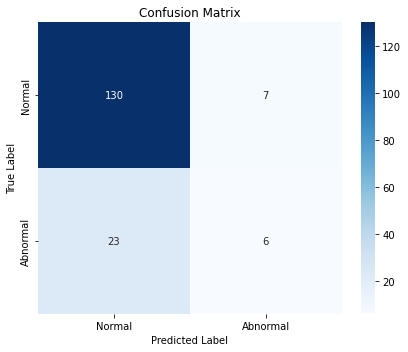

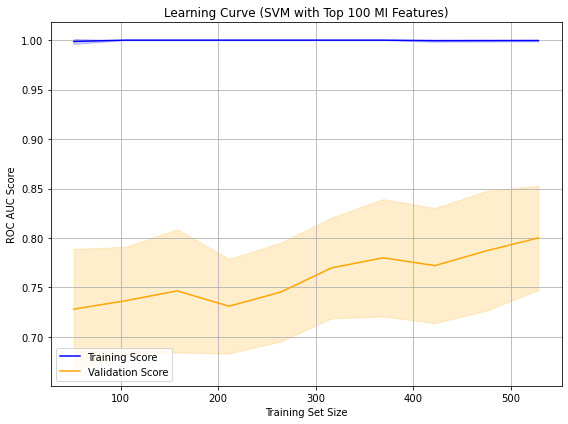

In [ ]:

## DIT DEEL MOET DUS ALLEMAAL VOORAF
df = pd.read_csv("ecg/ecg_data.csv")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
X = df.drop(columns=["label"])
y = df["label"]

# low_freq_features = [col for col in X.columns if int(col.split('_')[1]) < 100]
# X = X[low_freq_features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mi_scores = mutual_info_classif(X_train_scaled, y_train)
mi_feature_indices = np.argsort(mi_scores)[-2100:]  # Select top 2100 features
X_train_mi = X_train_scaled[:, mi_feature_indices]
X_val_mi = X_test_scaled[:, mi_feature_indices]

param_distributions = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Randomized search
random = RandomizedSearchCV(
    estimator=SVC(probability=True, class_weight='balanced'),
    param_distributions=param_distributions,  # ✅ correct key here
    scoring='roc_auc',
    n_iter=10,  # How many random combinations to try
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random.fit(X_train_mi, y_train)

best_svm = random.best_estimator_
print("Best Parameters:", random.best_params_)
print("Best ROC AUC (CV):", random.best_score_)

y_pred = best_svm.predict(X_val_mi)
y_prob = best_svm.predict_proba(X_val_mi)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
labels = ['Normal', 'Abnormal']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- Learning Curve ---
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_svm,
    X=X_train_mi,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation Score", color="orange")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve (SVM with Top 100 MI Features)")
plt.xlabel("Training Set Size")
plt.ylabel("ROC AUC Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


Flipped SVM (tot nu toe de hoogste F1 score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best ROC AUC (CV): 0.8178995725548711

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       137
           1       0.54      0.45      0.49        29

    accuracy                           0.84       166
   macro avg       0.71      0.68      0.70       166
weighted avg       0.83      0.84      0.83       166

Confusion Matrix:
[[126  11]
 [ 16  13]]
ROC AUC Score: 0.1994714321671281


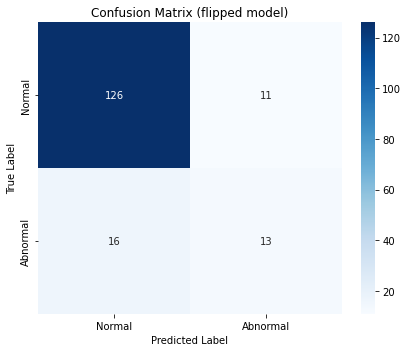

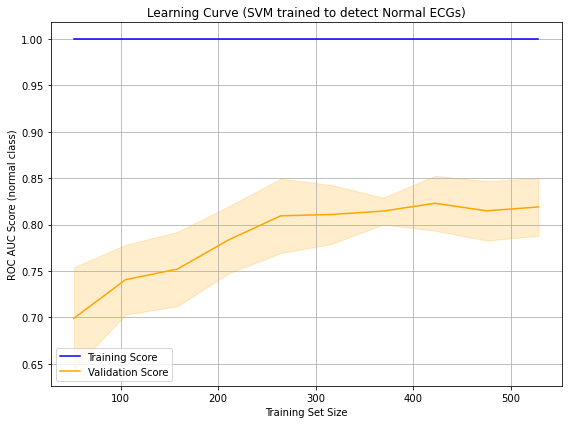

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("ecg/ecg_data.csv")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
X = df.drop(columns=["label"])
y = df["label"]

# Flip the labels: 1 = Normal, 0 = Abnormal
y_flipped = 1 - y

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_flipped, stratify=y_flipped, test_size=0.2, random_state=42
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mutual information for feature selection
mi_scores = mutual_info_classif(X_train_scaled, y_train)
mi_feature_indices = np.argsort(mi_scores)[-2100:]  # Select top 2100 features
X_train_mi = X_train_scaled[:, mi_feature_indices]
X_val_mi = X_test_scaled[:, mi_feature_indices]

# Define hyperparameter search space
param_distributions = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Randomized search
random = RandomizedSearchCV(
    estimator=SVC(probability=True, class_weight='balanced'),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random.fit(X_train_mi, y_train)

best_svm = random.best_estimator_
print("Best Parameters:", random.best_params_)
print("Best ROC AUC (CV):", random.best_score_)

# Predict using the flipped label model
y_prob = best_svm.predict_proba(X_val_mi)[:, 1]  # Probability of being NORMAL
threshold = 0.65
y_pred_flipped = (y_prob >= threshold).astype(int)     # Predict normal if high confidence

# Flip predictions and truth back for interpretation: 1 = Abnormal, 0 = Normal
y_test_original = 1 - y_test
y_pred_original = 1 - y_pred_flipped

print("\nClassification Report:")
print(classification_report(y_test_original, y_pred_original))

print("Confusion Matrix:")
cm = confusion_matrix(y_test_original, y_pred_original)
print(cm)

print("ROC AUC Score:", roc_auc_score(y_test_original, y_prob))

# --- Confusion Matrix Plot ---
labels = ['Normal', 'Abnormal']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (flipped model)')
plt.tight_layout()
plt.show()

# --- Learning Curve ---
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_svm,
    X=X_train_mi,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation Score", color="orange")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve (SVM trained to detect Normal ECGs)")
plt.xlabel("Training Set Size")
plt.ylabel("ROC AUC Score (normal class)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from xgboost import XGBClassifier

# Train-test split remains the same
# Feature selection remains the same (X_train_mi, X_val_mi)

# Estimate imbalance ratio for scale_pos_weight
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Define parameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=imbalance_ratio,  # important for imbalance!
    random_state=42
)

random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random.fit(X_train_mi, y_train)
best_model = random.best_estimator_

print("Best Parameters:", random.best_params_)
print("Best ROC AUC (CV):", random.best_score_)




Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\aryav\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best ROC AUC (CV): 0.8384732625192669
